In [1]:
from cassandra.cluster import Cluster, EXEC_PROFILE_GRAPH_DEFAULT
from cassandra.datastax.graph import GraphProtocol
from cassandra.datastax.graph.fluent import DseGraph

class DseLoader:
    def __init__(self, name):
        self.name = name

    def initialize(self):
         print("Initialize")

    def connect(self, ip):
         # Not blank
        if ip and ip.strip():
            self.ip = ip
        else:
            self.ip = '10.101.33.239' # default

        # Create an execution profile, using GraphSON3 for Core graphs
        self.ep = DseGraph.create_execution_profile(
            'gquotes',
            graph_protocol=GraphProtocol.GRAPHSON_3_0)

        self.cluster = Cluster(execution_profiles={EXEC_PROFILE_GRAPH_DEFAULT: self.ep}, contact_points=[self.ip])
        self.session = self.cluster.connect()

        self.g = DseGraph.traversal_source(session=self.session)


    def traverse(self):
        g = self.g

        traversal1 = g.V().has('person', 'name', 'Chet Kapoor').next()
    

        #for v in verts:
        #    print(v)

        #for e in g.E():
        #    print(e)

        # Vertices
        verts = g.V()
        for v in verts:
            print("***", v.id )
            #for p in g.V(v).properties():
                #name = p.properties('name').value()
            #    print("key:",p.label, "| value: " ,p.value)

        # Edges
        edges = g.E()
        for e in edges:
            print("***", e.id, '\n' , DseLoader.parseEdgeId(e.id) )
            #for p in g.E(e).properties():
            #    print("key:",e.label, "| value: " ,e.value)

        return g

    ##################################################################
    # DSE Graph 6.8.x encodes vertex and edge ids in a particular way
    # 

    #############################################
    # Parses a DSE edge id string into its components
    # Example:
    # dseg:/person-mentioned-quote/bf720fd3069c1704fd25359e1ebb77e531c4949a/069ae73d2bc4f54419a6c3fc56a0723c1b041740
    # Returns:
    # A dict with the following:
    # source_label: person
    # dest_label: quote
    # edge_label: mentioned
    # source_id: bf720fd3069c1704fd25359e1ebb77e531c4949a
    # dest_id: 069ae73d2bc4f54419a6c3fc56a0723c1b041740

    def parseEdgeId(str):
        result = {}

        str_list = str.split('/')
        edge_str = str_list[1]
        edge_list = edge_str.split('-')
        
        result['source_label'] = edge_list[0]
        result['dest_label'] = edge_list[2]
        result['edge_label'] = edge_list[1]
        result['source_id'] = str_list[2]
        result['dest_id'] = str_list[3]

        return result

    #############################################
    # Parses a DSE vertex id string into its components
    # Example:
    # dseg:/person/bf720fd3069c1704fd25359e1ebb77e531c4949a
    # Returns:
    # A dict with the following:
    # vertex_label: person
    # vertex_id: bf720fd3069c1704fd25359e1ebb77e531c4949a


    def parseVertexId(str):
        result = {}

        str_list = str.split('/')    
        result['vertex_label'] = str_list[1]
        result['vertex_id'] = str_list[2]
    

        return result

    ####################################
    # Convert Gremlin graph to Nx graph
    # returns a Networkx graph
    ####################################
    import networkx as nx

    def convertG2Nx(g):
        GG = nx.Graph()
        
        # Edges
        edges = g.E()
        for e in edges:
            es = DseLoader.parseEdgeId(e.id)
            print("*** Edges", e.id , es)
            GG.add_edge(es['source_id'], es['dest_id'], edge_label=es['edge_label'], \
                        source_label=es['source_label'], dest_label=es['dest_label'])
            #for p in g.E(e).properties():
            #    print("key:",e.label, "| value: " ,e.value)

            # TODO: Load edge properties

        # Vertices
        verts = g.V()
        for v in verts:
            vp = DseLoader.parseVertexId(v.id)
            print("*** Verts", v.id , vp)
            id = vp['vertex_id']
            for p in g.V(v).properties():
                print("key:",p.label, "| value: " ,p.value)
                GG.nodes[id][p.label] = p.value

        return GG

In [3]:
import networkx as nx
    
dl = DseLoader("ql1")         # Constructor
dl.initialize()                 # Init
dl.connect('10.101.33.239')     # Connect

g = dl.traverse()
gg = DseLoader.convertG2Nx(g)

Initialize
*** dseg:/person/bf720fd3069c1704fd25359e1ebb77e531c4949a
*** dseg:/person/42aba580cbb6d14a135608b986ec0f83662ca27d
*** dseg:/person/ffebfd619e41944982f5bff40e4dc7cc8c3d8a06
*** dseg:/person/9dd4f247e0c19df7abff72fb722dee3e6f137a92
*** dseg:/quote/c9c9b630bac8738acca222a648162f1d814eb683
*** dseg:/quote/dfdcdd6bdb7cb939704b1e4ecb25e384277191e3
*** dseg:/quote/3d2b5ec804edd25f719fdc69371cb78f5c50a10e
*** dseg:/quote/1327861b3cbf5101c29aa0932b7d45c7f94578c9
*** dseg:/quote/4f05b0f2cf1224d0b2ff13f2ba36fb38bbe88d88
*** dseg:/quote/67f94821358edb5ed92bc2a5ad8a5ae079c9680e
*** dseg:/quote/43910ccfb29237bd3166e09f5930fb4f134670ca
*** dseg:/quote/e4f4ca487bb9eb75cec6da9243129b93dcef3180
*** dseg:/quote/a59ad801a6770887b1d50873509c26fcadfaaa2f
*** dseg:/quote/f1b02cbe8f998ec289faddcb05726c501f7cb077
*** dseg:/quote/f8b68ea91241986a2b221860f3fe10ea1efb7253
*** dseg:/quote/069ae73d2bc4f54419a6c3fc56a0723c1b041740
*** dseg:/quote/594aa634da7539875618f4c550f8287ccddcb452
*** dseg:/quote/

*** dseg:/person-mentioned-quote/bf720fd3069c1704fd25359e1ebb77e531c4949a/069ae73d2bc4f54419a6c3fc56a0723c1b041740 
 {'dest_id': '069ae73d2bc4f54419a6c3fc56a0723c1b041740', 'edge_label': 'mentioned', 'source_label': 'person', 'source_id': 'bf720fd3069c1704fd25359e1ebb77e531c4949a', 'dest_label': 'quote'}
*** dseg:/person-mentioned-quote/bf720fd3069c1704fd25359e1ebb77e531c4949a/131c18cf82cbe09dd9b307ca1b0b7deadc2073d0 
 {'dest_id': '131c18cf82cbe09dd9b307ca1b0b7deadc2073d0', 'edge_label': 'mentioned', 'source_label': 'person', 'source_id': 'bf720fd3069c1704fd25359e1ebb77e531c4949a', 'dest_label': 'quote'}
*** dseg:/person-mentioned-quote/bf720fd3069c1704fd25359e1ebb77e531c4949a/144a0dceaa46feb081a793270415e1645ef69af5 
 {'dest_id': '144a0dceaa46feb081a793270415e1645ef69af5', 'edge_label': 'mentioned', 'source_label': 'person', 'source_id': 'bf720fd3069c1704fd25359e1ebb77e531c4949a', 'dest_label': 'quote'}
*** dseg:/person-mentioned-quote/bf720fd3069c1704fd25359e1ebb77e531c4949a/3d2b5ec8

 {'dest_id': '069ae73d2bc4f54419a6c3fc56a0723c1b041740', 'edge_label': 'foundin', 'source_label': 'keyword', 'source_id': 'leadership', 'dest_label': 'quote'}
*** dseg:/keyword-foundin-quote/leadership/bd84a23e19414c38b0f57f2bae96f8572d5aef88 
 {'dest_id': 'bd84a23e19414c38b0f57f2bae96f8572d5aef88', 'edge_label': 'foundin', 'source_label': 'keyword', 'source_id': 'leadership', 'dest_label': 'quote'}
*** dseg:/keyword-foundin-quote/building/92f8100f7e4c412dfb5091f6f17f0c3434bd286a 
 {'dest_id': '92f8100f7e4c412dfb5091f6f17f0c3434bd286a', 'edge_label': 'foundin', 'source_label': 'keyword', 'source_id': 'building', 'dest_label': 'quote'}
*** dseg:/keyword-foundin-quote/building/e545e95421a6c244698dff4dd3e9e91f63cc4aad 
 {'dest_id': 'e545e95421a6c244698dff4dd3e9e91f63cc4aad', 'edge_label': 'foundin', 'source_label': 'keyword', 'source_id': 'building', 'dest_label': 'quote'}
*** dseg:/keyword-foundin-quote/dollar/67f94821358edb5ed92bc2a5ad8a5ae079c9680e 
 {'dest_id': '67f94821358edb5ed92bc2

*** Edges dseg:/person-mentioned-quote/bf720fd3069c1704fd25359e1ebb77e531c4949a/069ae73d2bc4f54419a6c3fc56a0723c1b041740 {'dest_id': '069ae73d2bc4f54419a6c3fc56a0723c1b041740', 'edge_label': 'mentioned', 'source_label': 'person', 'source_id': 'bf720fd3069c1704fd25359e1ebb77e531c4949a', 'dest_label': 'quote'}
*** Edges dseg:/person-mentioned-quote/bf720fd3069c1704fd25359e1ebb77e531c4949a/131c18cf82cbe09dd9b307ca1b0b7deadc2073d0 {'dest_id': '131c18cf82cbe09dd9b307ca1b0b7deadc2073d0', 'edge_label': 'mentioned', 'source_label': 'person', 'source_id': 'bf720fd3069c1704fd25359e1ebb77e531c4949a', 'dest_label': 'quote'}
*** Edges dseg:/person-mentioned-quote/bf720fd3069c1704fd25359e1ebb77e531c4949a/144a0dceaa46feb081a793270415e1645ef69af5 {'dest_id': '144a0dceaa46feb081a793270415e1645ef69af5', 'edge_label': 'mentioned', 'source_label': 'person', 'source_id': 'bf720fd3069c1704fd25359e1ebb77e531c4949a', 'dest_label': 'quote'}
*** Edges dseg:/person-mentioned-quote/bf720fd3069c1704fd25359e1ebb77e

*** Edges dseg:/keyword-foundin-quote/find/18c501a7f235c3a18d27e02557e194c4dfff7478 {'dest_id': '18c501a7f235c3a18d27e02557e194c4dfff7478', 'edge_label': 'foundin', 'source_label': 'keyword', 'source_id': 'find', 'dest_label': 'quote'}
*** Edges dseg:/keyword-foundin-quote/find/3d2b5ec804edd25f719fdc69371cb78f5c50a10e {'dest_id': '3d2b5ec804edd25f719fdc69371cb78f5c50a10e', 'edge_label': 'foundin', 'source_label': 'keyword', 'source_id': 'find', 'dest_label': 'quote'}
*** Edges dseg:/keyword-foundin-quote/find/4f05b0f2cf1224d0b2ff13f2ba36fb38bbe88d88 {'dest_id': '4f05b0f2cf1224d0b2ff13f2ba36fb38bbe88d88', 'edge_label': 'foundin', 'source_label': 'keyword', 'source_id': 'find', 'dest_label': 'quote'}
*** Edges dseg:/keyword-foundin-quote/collaboration/4f05b0f2cf1224d0b2ff13f2ba36fb38bbe88d88 {'dest_id': '4f05b0f2cf1224d0b2ff13f2ba36fb38bbe88d88', 'edge_label': 'foundin', 'source_label': 'keyword', 'source_id': 'collaboration', 'dest_label': 'quote'}
*** Edges dseg:/keyword-foundin-quote/

key: snippet | value:  The first thing you have to do when you get on this data-driven enterprise journey is to make sure our strategy is crisp and clear and not just in the leadership team, not just the executive team, but it should be as clear as possible to every individual in the enterprise.
key: quote_id | value:  069ae73d2bc4f54419a6c3fc56a0723c1b041740
*** Verts dseg:/quote/594aa634da7539875618f4c550f8287ccddcb452 {'vertex_label': 'quote', 'vertex_id': '594aa634da7539875618f4c550f8287ccddcb452'}
key: snippet | value:  Deliver solutions that are flexible, modern and cutting-edge.
key: quote_id | value:  594aa634da7539875618f4c550f8287ccddcb452
*** Verts dseg:/quote/682dffe91efc5b2693861417c31604fd1f789751 {'vertex_label': 'quote', 'vertex_id': '682dffe91efc5b2693861417c31604fd1f789751'}
key: snippet | value:  A platform is only a platform when you stand on it.
key: quote_id | value:  682dffe91efc5b2693861417c31604fd1f789751
*** Verts dseg:/quote/84ff49825b94b74675438065866e77cd65

key: key | value:  terms
*** Verts dseg:/keyword/org {'vertex_label': 'keyword', 'vertex_id': 'org'}
key: key | value:  org
*** Verts dseg:/keyword/users {'vertex_label': 'keyword', 'vertex_id': 'users'}
key: key | value:  users
*** Verts dseg:/keyword/operations {'vertex_label': 'keyword', 'vertex_id': 'operations'}
key: key | value:  operations
*** Verts dseg:/keyword/inertia {'vertex_label': 'keyword', 'vertex_id': 'inertia'}
key: key | value:  inertia
*** Verts dseg:/keyword/regular {'vertex_label': 'keyword', 'vertex_id': 'regular'}
key: key | value:  regular
*** Verts dseg:/keyword/hands {'vertex_label': 'keyword', 'vertex_id': 'hands'}
key: key | value:  hands
*** Verts dseg:/keyword/runs {'vertex_label': 'keyword', 'vertex_id': 'runs'}
key: key | value:  runs
*** Verts dseg:/keyword/sure {'vertex_label': 'keyword', 'vertex_id': 'sure'}
key: key | value:  sure
*** Verts dseg:/keyword/committers {'vertex_label': 'keyword', 'vertex_id': 'committers'}
key: key | value:  committers


*** Verts dseg:/keyword/sound {'vertex_label': 'keyword', 'vertex_id': 'sound'}
key: key | value:  sound
*** Verts dseg:/keyword/five {'vertex_label': 'keyword', 'vertex_id': 'five'}
key: key | value:  five
*** Verts dseg:/keyword/culture {'vertex_label': 'keyword', 'vertex_id': 'culture'}
key: key | value:  culture
*** Verts dseg:/keyword/experience {'vertex_label': 'keyword', 'vertex_id': 'experience'}
key: key | value:  experience
*** Verts dseg:/keyword/found {'vertex_label': 'keyword', 'vertex_id': 'found'}
key: key | value:  found
*** Verts dseg:/keyword/structural {'vertex_label': 'keyword', 'vertex_id': 'structural'}
key: key | value:  structural
*** Verts dseg:/keyword/owners {'vertex_label': 'keyword', 'vertex_id': 'owners'}
key: key | value:  owners
*** Verts dseg:/keyword/technologies {'vertex_label': 'keyword', 'vertex_id': 'technologies'}
key: key | value:  technologies
*** Verts dseg:/keyword/worry {'vertex_label': 'keyword', 'vertex_id': 'worry'}
key: key | value:  worr

*** Verts dseg:/keyword/jelly {'vertex_label': 'keyword', 'vertex_id': 'jelly'}
key: key | value:  jelly
*** Verts dseg:/keyword/development {'vertex_label': 'keyword', 'vertex_id': 'development'}
key: key | value:  development
*** Verts dseg:/keyword/services {'vertex_label': 'keyword', 'vertex_id': 'services'}
key: key | value:  services
*** Verts dseg:/keyword/impediment {'vertex_label': 'keyword', 'vertex_id': 'impediment'}
key: key | value:  impediment
*** Verts dseg:/keyword/like {'vertex_label': 'keyword', 'vertex_id': 'like'}
key: key | value:  like
*** Verts dseg:/keyword/create {'vertex_label': 'keyword', 'vertex_id': 'create'}
key: key | value:  create
*** Verts dseg:/keyword/sometimes {'vertex_label': 'keyword', 'vertex_id': 'sometimes'}
key: key | value:  sometimes
*** Verts dseg:/keyword/work {'vertex_label': 'keyword', 'vertex_id': 'work'}
key: key | value:  work
*** Verts dseg:/keyword/industry {'vertex_label': 'keyword', 'vertex_id': 'industry'}
key: key | value:  indu

In [29]:
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

nodes = [{'name': str(i)}
         for i in gg.nodes()]
#print("Nodes: ", nodes)

links = [{'source': u[0], 'target': u[1]}
         for u in gg.edges()]

#print("Edges: ", links)
output_txt = 'Hello World'

with open('graph.json', 'w') as f:
    #json.dump({'nodes': nodes, 'links': links}, f, indent=4,)
    f.write("Hello")

graph_str = json.dumps({'nodes': nodes, 'links': links})

print(graph_str)
    

{"links": [{"target": "cassandra", "source": "daa02698-df4f-4436-8855-941774f4c3e0"}, {"target": "apache", "source": "daa02698-df4f-4436-8855-941774f4c3e0"}, {"target": "e7cd5752-bc0d-4157-a80f-7523add8dbcd", "source": "daa02698-df4f-4436-8855-941774f4c3e0"}, {"target": "think", "source": "daa02698-df4f-4436-8855-941774f4c3e0"}, {"target": "enterprises", "source": "c706605c1d6a336acb50cd4052204ae486599c45"}, {"target": "ask", "source": "c706605c1d6a336acb50cd4052204ae486599c45"}, {"target": "bf720fd3069c1704fd25359e1ebb77e531c4949a", "source": "c706605c1d6a336acb50cd4052204ae486599c45"}, {"target": "succeed", "source": "c706605c1d6a336acb50cd4052204ae486599c45"}, {"target": "really", "source": "c706605c1d6a336acb50cd4052204ae486599c45"}, {"target": "drive", "source": "c706605c1d6a336acb50cd4052204ae486599c45"}, {"target": "regular", "source": "c706605c1d6a336acb50cd4052204ae486599c45"}, {"target": "hard", "source": "c706605c1d6a336acb50cd4052204ae486599c45"}, {"target": "basis", "sourc

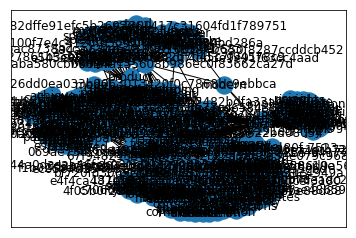

In [10]:
nx.draw_networkx(gg)

In [31]:
from IPython.core.display import HTML
HTML('''
<h1>Hello DOM!</h1>
''')

In [32]:
HTML('<script src="lib/d3/d3.min.js"></script>')

In [38]:
from IPython.core.display import display, HTML
from string import Template
import json

HTML('')

css_text = '''
'''

js_text_template = Template('''

    require.config({paths: {d3: "http://d3js.org/d3.v3.min"}});

    require(["d3"], function(d3) {
      // code that uses D3 goes here…
      // e.g., console.log(d3.version);
    });

       var bogoSVG = d3.select("#$bogoanimation") 
          .append("svg")
          .attr("width", 300)
          .attr("height", 300);    

      var data = $python_data ;
       bogoSVG.append("circle")
          .style("stroke", "gray")
          .style("fill", "cyan")
          .attr("r", data[0]['r'])
          .attr("cx", data[0]['cx'])
          .attr("cy", data[0]['cy'])
          .transition()
             .delay(100)
             .duration(10000)  
             .attr("r", 10)
             .attr("cx", data[0]['cx'])
             .style("fill", "blue"); 
''')

html_template = Template('''
''')

js_text = js_text_template.substitute({'python_data': json.dumps([{'r': 130, 'cx': 150, 'cy': 150}]),
    'bogoanimation': 'animation'})



HTML(html_template.substitute({'css_text': css_text, 'js_text': js_text}))

In [39]:
# import libraries (including our short d3_lib script)
from IPython.core.display import HTML
import d3_lib, random

ImportError: No module named 'd3_lib'